In [5]:
import numpy as np
import matplotlib.pyplot as plt

def noise_psd(N, psd = lambda f: 1):
        X_white = np.fft.rfft(np.random.randn(N));
        S = psd(np.fft.rfftfreq(N))
        # Normalize S
        S = S / np.sqrt(np.mean(S**2))
        X_shaped = X_white * S;
        return np.fft.irfft(X_shaped);

def PSDGenerator(f):
    return lambda N: noise_psd(N, f)

@PSDGenerator
def white_noise(f):
    return 1

@PSDGenerator
def blue_noise(f):
    return np.sqrt(f)

@PSDGenerator
def violet_noise(f):
    return f

@PSDGenerator
def brownian_noise(f):
    return 1/np.where(f == 0, float('inf'), f)

@PSDGenerator
def pink_noise(f):
    K = 3
    return np.where(f == 0, 1/float('inf'), np.sqrt(K**2/(2*np.pi)*1/f))

/var/folders/c_/g325g29n59vf3rg89kh6drb00000gp/T/ipykernel_4252/1430423751.py:7: RuntimeWarning: divide by zero encountered in divide
  pink_noise = np.convolve(white_noise, 1 / (f**dsp), mode='same')


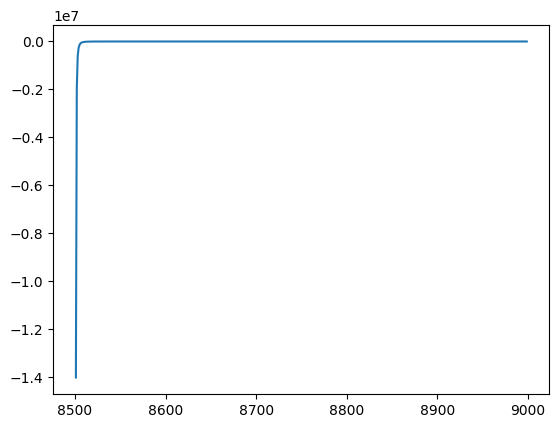

In [11]:
def generate_pink_noise(duration, sample_rate, dsp=0.1):
    # Generate white noise
    white_noise = np.random.randn(duration * sample_rate)

    # Convert white noise to pink noise using a 1/f filter
    f = np.linspace(0, sample_rate / 2, duration)
    pink_noise = np.convolve(white_noise, 1 / (f**dsp), mode='same')

    return pink_noise


x = generate_pink_noise(
    duration=1000,
    sample_rate=10,
    dsp=3,
)
plt.plot(x[1000:])

In [101]:
"""Generate colored noise."""

from typing import Union, Iterable, Optional
from numpy import sqrt, newaxis, integer
from numpy.fft import irfft, rfftfreq
from numpy.random import default_rng, Generator, RandomState
from numpy import sum as npsum


def powerlaw_psd_gaussian(
        exponent: float, 
        size: Union[int, Iterable[int]], 
        fmin: float = 0.0, 
        random_state: Optional[Union[int, Generator, RandomState]] = None
    ):
    """Gaussian (1/f)**beta noise.

    Based on the algorithm in:
    Timmer, J. and Koenig, M.:
    On generating power law noise.
    Astron. Astrophys. 300, 707-710 (1995)

    Normalised to unit variance

    Parameters:
    -----------

    exponent : float
        The power-spectrum of the generated noise is proportional to

        S(f) = (1 / f)**beta
        flicker / pink noise:   exponent beta = 1
        brown noise:            exponent beta = 2

        Furthermore, the autocorrelation decays proportional to lag**-gamma
        with gamma = 1 - beta for 0 < beta < 1.
        There may be finite-size issues for beta close to one.

    shape : int or iterable
        The output has the given shape, and the desired power spectrum in
        the last coordinate. That is, the last dimension is taken as time,
        and all other components are independent.

    fmin : float, optional
        Low-frequency cutoff.
        Default: 0 corresponds to original paper. 
        
        The power-spectrum below fmin is flat. fmin is defined relative
        to a unit sampling rate (see numpy's rfftfreq). For convenience,
        the passed value is mapped to max(fmin, 1/samples) internally
        since 1/samples is the lowest possible finite frequency in the
        sample. The largest possible value is fmin = 0.5, the Nyquist
        frequency. The output for this value is white noise.

    random_state :  int, numpy.integer, numpy.random.Generator, numpy.random.RandomState, 
                    optional
        Optionally sets the state of NumPy's underlying random number generator.
        Integer-compatible values or None are passed to np.random.default_rng.
        np.random.RandomState or np.random.Generator are used directly.
        Default: None.

    Returns
    -------
    out : array
        The samples.


    Examples:
    ---------

    # generate 1/f noise == pink noise == flicker noise
    >>> import colorednoise as cn
    >>> y = cn.powerlaw_psd_gaussian(1, 5)
    """
    
    # Make sure size is a list so we can iterate it and assign to it.
    if isinstance(size, (integer, int)):
        size = [size]
    elif isinstance(size, Iterable):
        size = list(size)
    else:
        raise ValueError("Size must be of type int or Iterable[int]")
    
    # The number of samples in each time series
    samples = size[-1]
    
    # Calculate Frequencies (we asume a sample rate of one)
    # Use fft functions for real output (-> hermitian spectrum)
    f = rfftfreq(samples) # type: ignore # mypy 1.5.1 has problems here 
    
    # Validate / normalise fmin
    if 0 <= fmin <= 0.5:
        fmin = max(fmin, 1./samples) # Low frequency cutoff
    else:
        raise ValueError("fmin must be chosen between 0 and 0.5.")
    
    # Build scaling factors for all frequencies
    s_scale = f
    ix   = npsum(s_scale < fmin)   # Index of the cutoff
    if ix and ix < len(s_scale):
        s_scale[:ix] = s_scale[ix]
    s_scale = s_scale**(-exponent/2.)
    
    # Calculate theoretical output standard deviation from scaling
    w      = s_scale[1:].copy()
    w[-1] *= (1 + (samples % 2)) / 2. # correct f = +-0.5
    sigma = 2 * sqrt(npsum(w**2)) / samples
    
    # Adjust size to generate one Fourier component per frequency
    size[-1] = len(f)

    # Add empty dimension(s) to broadcast s_scale along last
    # dimension of generated random power + phase (below)
    dims_to_add = len(size) - 1
    s_scale     = s_scale[(newaxis,) * dims_to_add + (Ellipsis,)]
    
    # prepare random number generator
    normal_dist = _get_normal_distribution(random_state)

    # Generate scaled random power + phase
    sr = normal_dist(scale=s_scale, size=size)
    si = normal_dist(scale=s_scale, size=size)
    
    # If the signal length is even, frequencies +/- 0.5 are equal
    # so the coefficient must be real.
    if not (samples % 2):
        si[..., -1] = 0
        sr[..., -1] *= sqrt(2)    # Fix magnitude

    # Regardless of signal length, the DC component must be real
    si[..., 0] = 0
    sr[..., 0] *= sqrt(2)    # Fix magnitude

    # Combine power + corrected phase to Fourier components
    s  = sr + 1J * si

    # Transform to real time series & scale to unit variance
    y = irfft(s, n=samples, axis=-1) / sigma

    return y


def _get_normal_distribution(random_state: Optional[Union[int, Generator, RandomState]]):
    normal_dist = None
    if isinstance(random_state, (integer, int)) or random_state is None:
        random_state = default_rng(random_state)
        normal_dist = random_state.normal
    elif isinstance(random_state, (Generator, RandomState)):
        normal_dist = random_state.normal
    else:
        raise ValueError(
            "random_state must be one of integer, numpy.random.Generator, "
            "numpy.random.Randomstate"
        )
    return normal_dist

In [102]:
N = 100000

In [103]:
x = white_noise(N)

print(np.std(x))

1.0017520079592004


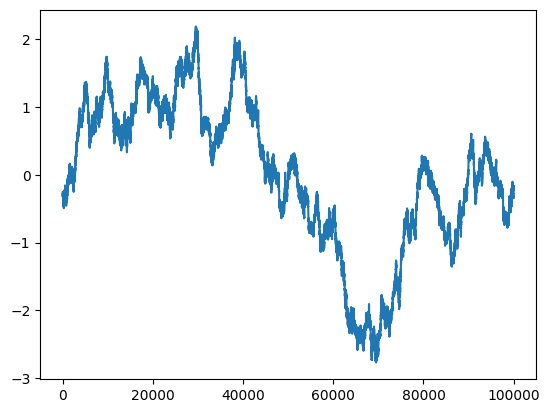

In [104]:
x = brownian_noise(N)
plt.plot(x)

180.52820792465047
white      16.521878
flicker     0.000000
walk        0.000000
Name: 0, dtype: float64


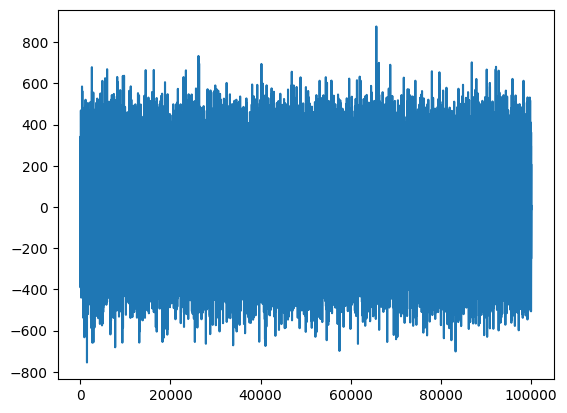

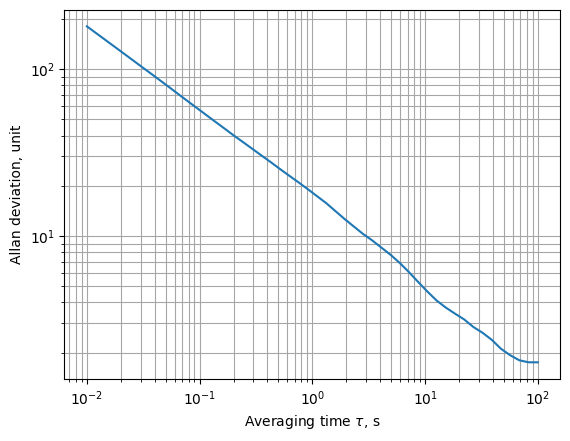

In [105]:
from firefly.math.noise import white_noise
from firefly.math.allan import allan_variance,plot_allan_deviation, params_from_avar


fs = 100
x = 18. * white_noise(N,fs=fs)
plt.plot(x)
print(np.std(x))


(tau, adev,) = allan_variance(x, dt=1/fs,n_clusters=50)

plot_allan_deviation(tau, adev)

params, av_pred  = params_from_avar(tau, adev,effects=['walk','white','flicker'])


print(params)

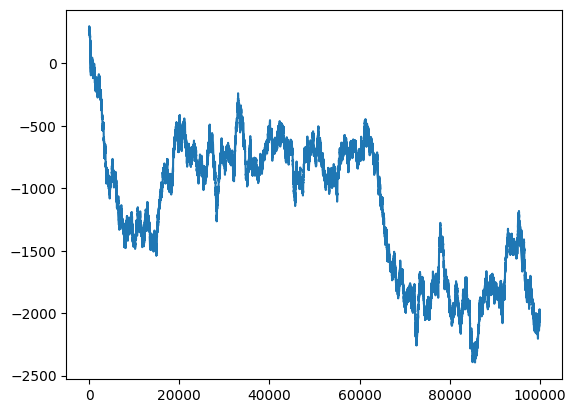

In [106]:
from firefly.math.allan import allan_variance, params_from_avar, plot_allan_deviation


x = RedNoise(1,1E-6)
plt.plot(x.get_series(N))

# (tau, adev,) = allan_variance(x, dt=1.0)

# plot_allan_deviation(tau, adev)

# params, av_pred  = params_from_avar(tau, adev,effects=['walk'])


# print(params)

white      0.000000
flicker    0.400365
walk       3.701408
Name: 0, dtype: float64


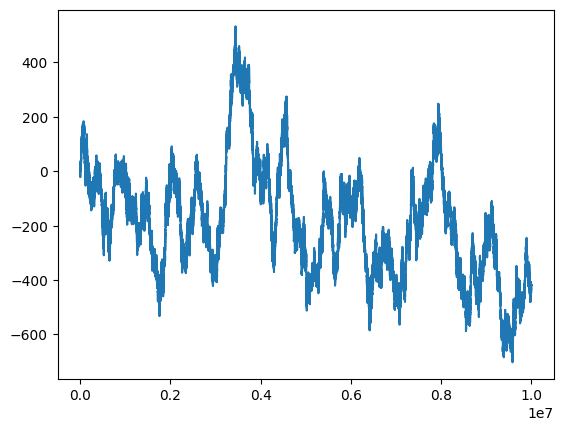

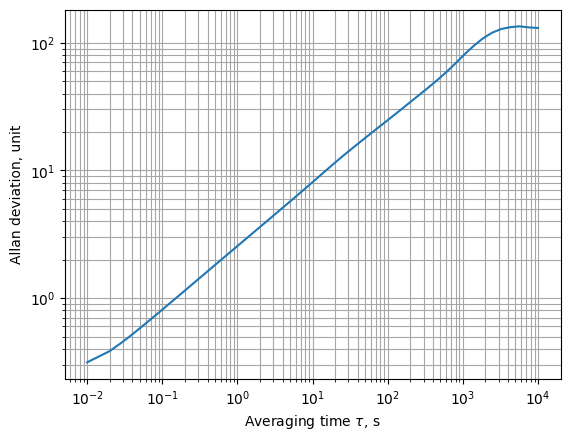

In [107]:
from allantools import noise as allan_noise

x = allan_noise.brown(
    N*100,
    fs=100
)
plt.plot(x)

(tau, adev,) = allan_variance(x, dt=1/fs,n_clusters=50)

plot_allan_deviation(tau, adev)

params, av_pred  = params_from_avar(tau, adev,effects=['walk','white','flicker'])


print(params)



white      0.000000
flicker    0.007605
walk       0.009579
Name: 0, dtype: float64


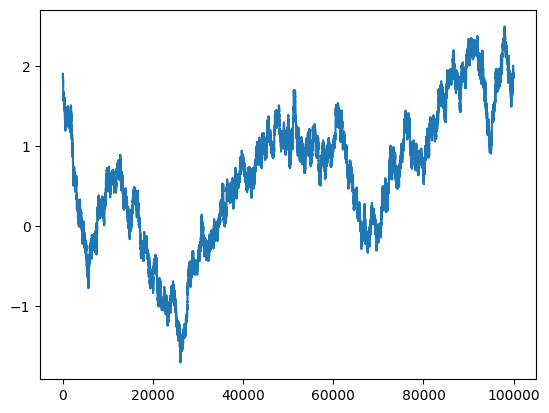

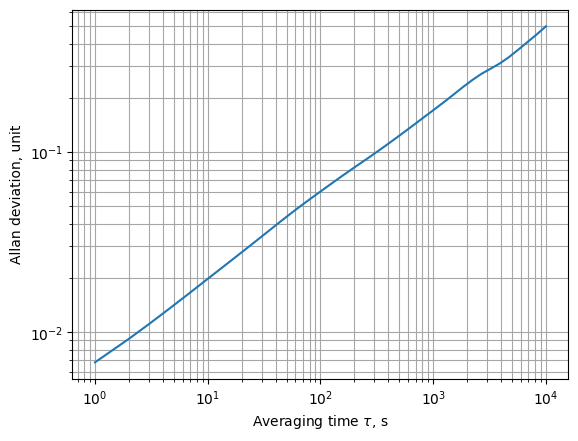

In [108]:
from firefly.math.allan import allan_variance,plot_allan_deviation, params_from_avar

beta = 2 # the exponent
samples = N*1 # number of samples to generate
y = powerlaw_psd_gaussian(beta, samples)

plt.plot(y)

(tau, adev,) = allan_variance(y, dt=1.0,n_clusters=50)

plot_allan_deviation(tau, adev)

params, av_pred  = params_from_avar(tau, adev,effects=['walk','white','flicker'])


print(params)

walk    0.997145
Name: 0, dtype: float64
1.0


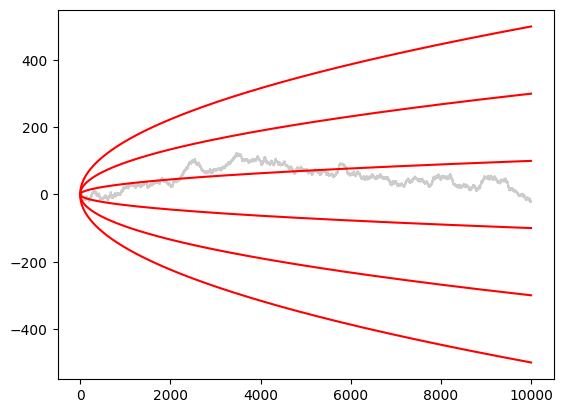

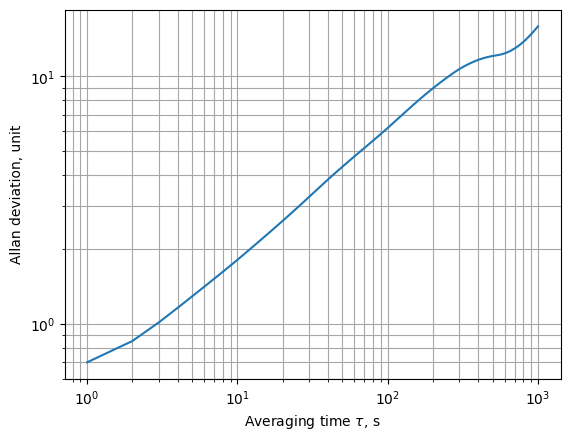

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from firefly.math.allan import allan_variance,plot_allan_deviation, params_from_avar

R= 1.
t0 = 0
dt =1.
tf = 10000
t = np.arange(t0,tf,dt)

rng = np.random.RandomState()
walk =  np.cumsum((R/dt)** 0.5 * rng.randn(len(t)))*dt


sig = np.sqrt(R*t)



for idx in range(1):
    walk =  np.cumsum((R/dt)** 0.5*rng.randn(len(t)))*dt
    plt.plot(t,walk,c="black", alpha=0.2)

plt.plot(t,sig,c="red")
plt.plot(t,-sig,c="red")
plt.plot(t,3*sig,c="red")
plt.plot(t,-3*sig,c="red")
plt.plot(t,5*sig,c="red")
plt.plot(t,-5*sig,c="red")

(tau, adev,) = allan_variance(walk, dt=dt,n_clusters=100)

plot_allan_deviation(tau, adev)

params, av_pred  = params_from_avar(tau, adev,effects=['walk'])


print(params)
print(np.sqrt(R))

walk    4.155838
Name: 0, dtype: float64
1.0


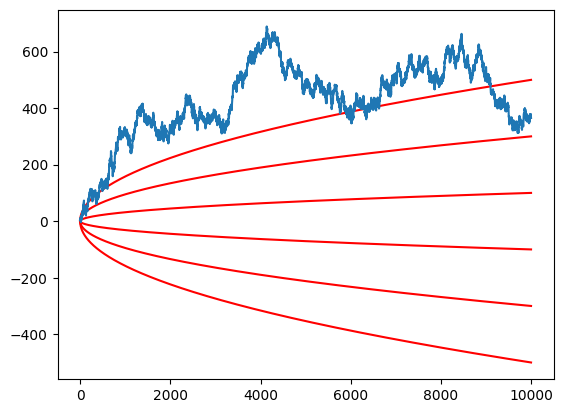

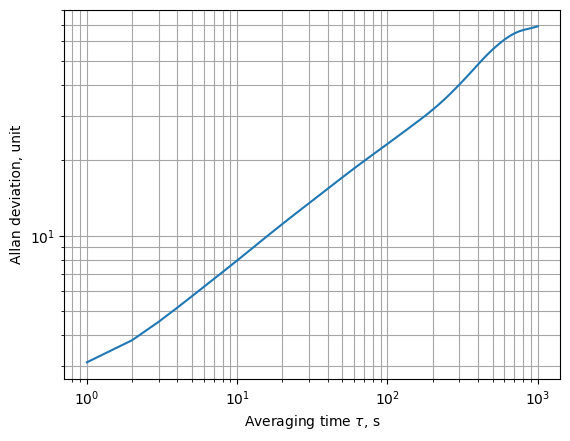

In [110]:
from allantools import noise as allan_noise

x = allan_noise.pink(
    num_points=len(t),
    fs=1/dt,
    b2=R
)

sig = np.sqrt(R*t)

plt.plot(t,sig,c="red")
plt.plot(t,-sig,c="red")
plt.plot(t,3*sig,c="red")
plt.plot(t,-3*sig,c="red")
plt.plot(t,5*sig,c="red")
plt.plot(t,-5*sig,c="red")
plt.plot(t,x)

(tau, adev,) = allan_variance(x, dt=dt,n_clusters=100)

plot_allan_deviation(tau, adev)

params, av_pred  = params_from_avar(tau, adev,effects=['walk'])


print(params)
print(R)

In [1]:
"""Generate colored noise."""

from typing import Union, Iterable, Optional
from numpy import sqrt, newaxis, integer
from numpy.fft import irfft, rfftfreq
from numpy.random import default_rng, Generator, RandomState
from numpy import sum as npsum


def powerlaw_psd_gaussian(
        exponent: float, 
        size: Union[int, Iterable[int]], 
        fmin: float = 0.0, 
        random_state: Optional[Union[int, Generator, RandomState]] = None
    ):
    """Gaussian (1/f)**beta noise.

    Based on the algorithm in:
    Timmer, J. and Koenig, M.:
    On generating power law noise.
    Astron. Astrophys. 300, 707-710 (1995)

    Normalised to unit variance

    Parameters:
    -----------

    exponent : float
        The power-spectrum of the generated noise is proportional to

        S(f) = (1 / f)**beta
        flicker / pink noise:   exponent beta = 1
        brown noise:            exponent beta = 2

        Furthermore, the autocorrelation decays proportional to lag**-gamma
        with gamma = 1 - beta for 0 < beta < 1.
        There may be finite-size issues for beta close to one.

    shape : int or iterable
        The output has the given shape, and the desired power spectrum in
        the last coordinate. That is, the last dimension is taken as time,
        and all other components are independent.

    fmin : float, optional
        Low-frequency cutoff.
        Default: 0 corresponds to original paper. 
        
        The power-spectrum below fmin is flat. fmin is defined relative
        to a unit sampling rate (see numpy's rfftfreq). For convenience,
        the passed value is mapped to max(fmin, 1/samples) internally
        since 1/samples is the lowest possible finite frequency in the
        sample. The largest possible value is fmin = 0.5, the Nyquist
        frequency. The output for this value is white noise.

    random_state :  int, numpy.integer, numpy.random.Generator, numpy.random.RandomState, 
                    optional
        Optionally sets the state of NumPy's underlying random number generator.
        Integer-compatible values or None are passed to np.random.default_rng.
        np.random.RandomState or np.random.Generator are used directly.
        Default: None.

    Returns
    -------
    out : array
        The samples.


    Examples:
    ---------

    # generate 1/f noise == pink noise == flicker noise
    >>> import colorednoise as cn
    >>> y = cn.powerlaw_psd_gaussian(1, 5)
    """
    
    # Make sure size is a list so we can iterate it and assign to it.
    if isinstance(size, (integer, int)):
        size = [size]
    elif isinstance(size, Iterable):
        size = list(size)
    else:
        raise ValueError("Size must be of type int or Iterable[int]")
    
    # The number of samples in each time series
    samples = size[-1]
    
    # Calculate Frequencies (we asume a sample rate of one)
    # Use fft functions for real output (-> hermitian spectrum)
    f = rfftfreq(samples) # type: ignore # mypy 1.5.1 has problems here 
    
    # Validate / normalise fmin
    if 0 <= fmin <= 0.5:
        fmin = max(fmin, 1./samples) # Low frequency cutoff
    else:
        raise ValueError("fmin must be chosen between 0 and 0.5.")
    
    # Build scaling factors for all frequencies
    s_scale = f    
    ix   = npsum(s_scale < fmin)   # Index of the cutoff
    if ix and ix < len(s_scale):
        s_scale[:ix] = s_scale[ix]
    s_scale = s_scale**(-exponent/2.)
    
    # Calculate theoretical output standard deviation from scaling
    w      = s_scale[1:].copy()
    w[-1] *= (1 + (samples % 2)) / 2. # correct f = +-0.5
    sigma = 2 * sqrt(npsum(w**2)) / samples
    
    # Adjust size to generate one Fourier component per frequency
    size[-1] = len(f)

    # Add empty dimension(s) to broadcast s_scale along last
    # dimension of generated random power + phase (below)
    dims_to_add = len(size) - 1
    s_scale     = s_scale[(newaxis,) * dims_to_add + (Ellipsis,)]
    
    # prepare random number generator
    normal_dist = _get_normal_distribution(random_state)

    # Generate scaled random power + phase
    sr = normal_dist(scale=s_scale, size=size)
    si = normal_dist(scale=s_scale, size=size)
    
    # If the signal length is even, frequencies +/- 0.5 are equal
    # so the coefficient must be real.
    if not (samples % 2):
        si[..., -1] = 0
        sr[..., -1] *= sqrt(2)    # Fix magnitude
    
    # Regardless of signal length, the DC component must be real
    si[..., 0] = 0
    sr[..., 0] *= sqrt(2)    # Fix magnitude
    
    # Combine power + corrected phase to Fourier components
    s  = sr + 1J * si
    
    # Transform to real time series & scale to unit variance
    y = irfft(s, n=samples, axis=-1) / sigma
    
    return y


def _get_normal_distribution(random_state: Optional[Union[int, Generator, RandomState]]):
    normal_dist = None
    if isinstance(random_state, (integer, int)) or random_state is None:
        random_state = default_rng(random_state)
        normal_dist = random_state.normal
    elif isinstance(random_state, (Generator, RandomState)):
        normal_dist = random_state.normal
    else:
        raise ValueError(
            "random_state must be one of integer, numpy.random.Generator, "
            "numpy.random.Randomstate"
        )
    return normal_dist

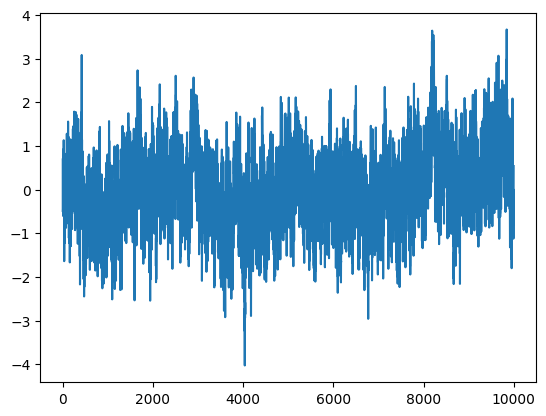

In [4]:
import numpy as np
import matplotlib.pyplot as plt
y = powerlaw_psd_gaussian(1, 10000)

plt.plot(y)